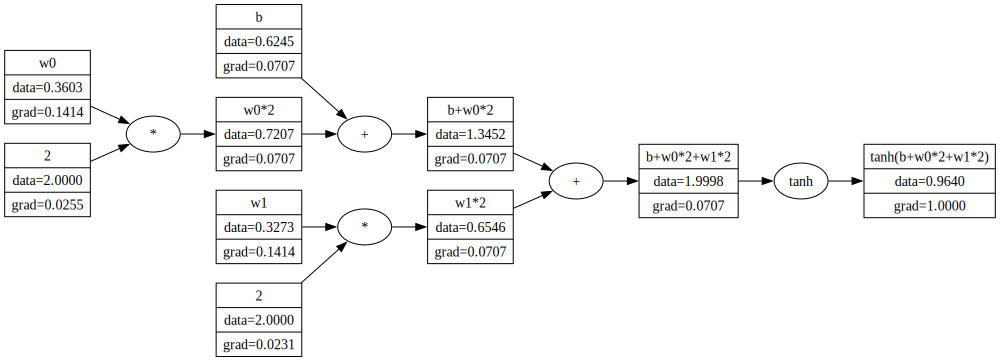

In [1]:
from graph_drawer import GraphDrawer
from predictors import Neuron

# create a neuron and run a backward pass
n = Neuron(2)
o = n([2, 2])
o.backward()

# draw the graph for that neuron
d = GraphDrawer()
d.draw(o)

In [9]:
import random
import numpy as np
np.random.seed(1337)
random.seed(1337)

# make up a dataset
from sklearn.datasets import make_moons, make_classification
NUM_SAMPLES = 100
X, Y = make_moons(n_samples=NUM_SAMPLES, noise=0.1)
# X = [(-1, -1), (0, 0), (1, 1), (2, 2)]
# Y = [-1, -1, 1, 1]
# X, Y = make_classification(n_samples = NUM_SAMPLES, n_features=2, n_redundant=0,n_classes=2)

USE_BINARY = False
NEGATIVE_LABEL = 0
POSITIVE_LABEL = 1


if USE_BINARY is False:
    NEGATIVE_LABEL = 0
    POSITIVE_LABEL = 1
    Y = Y*2 - 1 # make Y -1 or 1

AVERAGE_LABEL = (POSITIVE_LABEL + NEGATIVE_LABEL) / 2.0
    
    




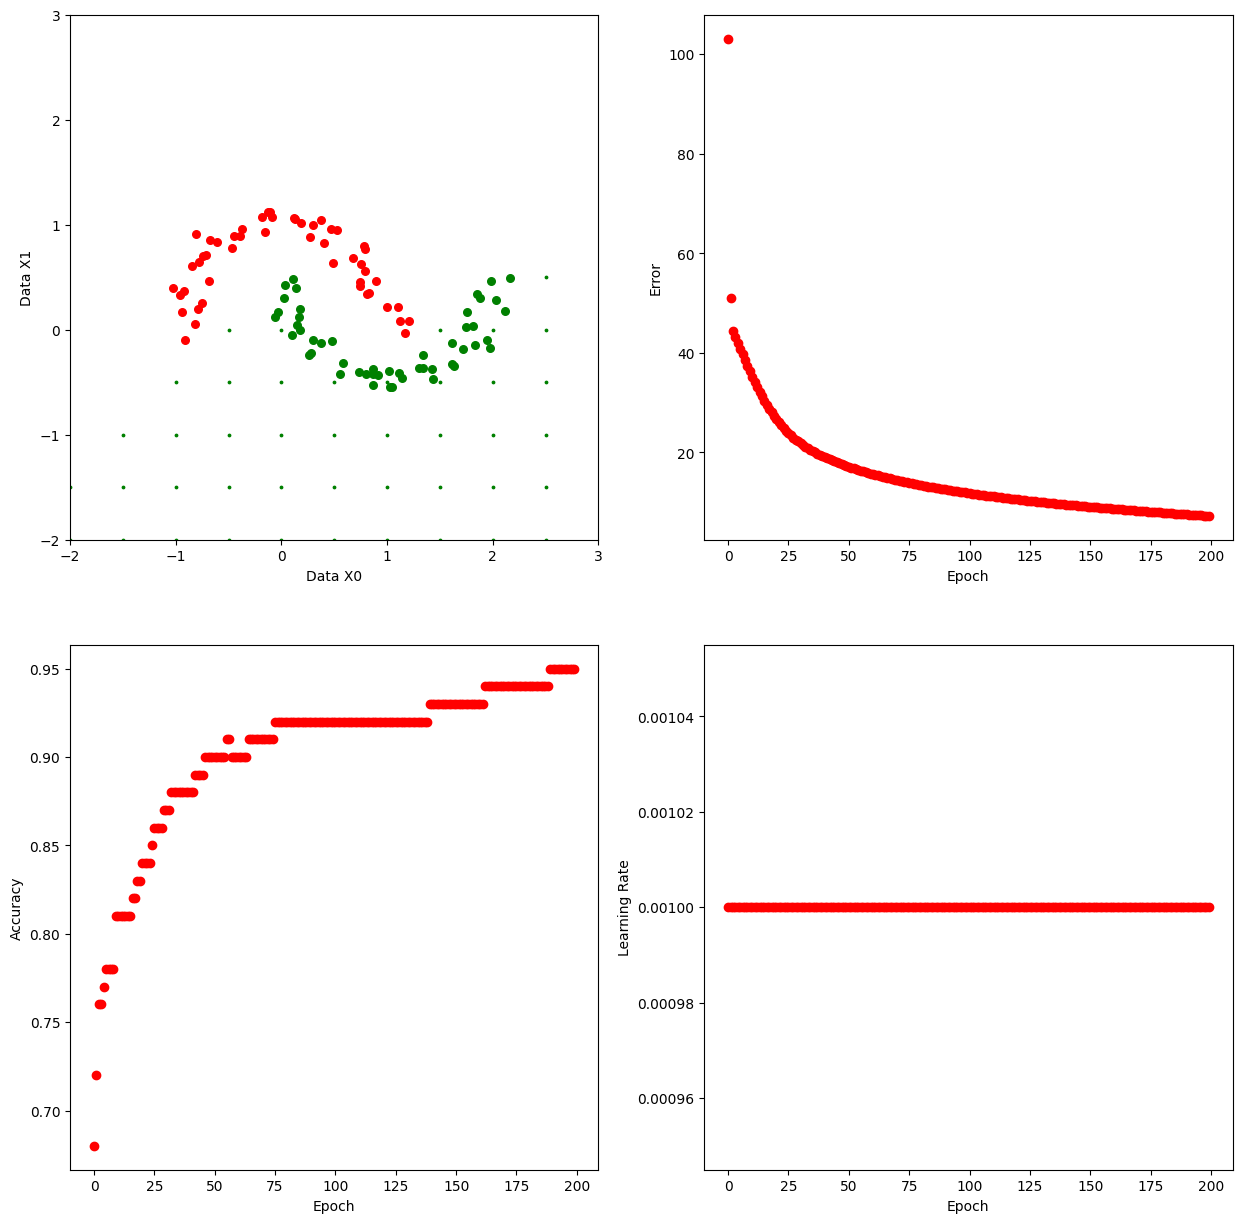

In [11]:
from IPython.display import display, clear_output
from matplotlib import pyplot as plt

from value import Value
from predictors import MLP, Neuron


def get_loss(prediction_value, y_value):
    diff = prediction_value - y_value;
    prod = diff ** 2
    return prod


def get_loss1(prediction_value, y_value):
    f1 = lambda x: (x + 1) / 2.0
    f2 = lambda x: (-x + 1) / 2.0
    pred1 = f1(prediction_value)
    pred2 = f2(prediction_value)
    pred1_ln = pred1.ln()
    pred2_ln = pred2.ln()
    product1 = f1(y_value) * pred1_ln
    product2 = f2(y_value) * pred2_ln
    return -(product1 + product2)


def train(X, Y, n, plotter):
    EPOCHS = 200
    DELTA = 0.001
    
    for k in range(EPOCHS):
        # run a foward pass
        error = Value(0, label='error')
        correct_predictions = 0.0
        incorrect_predictions = 0.0
        for index, (x, y) in enumerate(zip(X, Y)):
            xi0 = Value(x[0], label=f'x{index}[0]')
            xi1 = Value(x[1], label=f'x{index}[1]')
            prediction_value = n([xi0, xi1])
            y_value = Value(y, label='y')
            error = get_loss(prediction_value, y_value) + error
            if y_value.data < AVERAGE_LABEL and prediction_value.data < AVERAGE_LABEL:
                correct_predictions += 1
            elif y_value.data > AVERAGE_LABEL and prediction_value.data > AVERAGE_LABEL:
                correct_predictions += 1
            else:
                incorrect_predictions += 1

        # run a backward pass
        error.backward()
    
        # adjust the weights
        for p in n.parameters():
            p.data = p.data - DELTA * p.grad

        # reset the gradients
        for p in n.parameters():
            p.grad = 0
            
        # visualize the decision boundary
        plotter.show_decision_boundary_and_stats(n, error, k, correct_predictions, incorrect_predictions, DELTA)

    

class Plotter:

    def __init__(self, X, Y):
        # Create a figure for visualization the data
        self.fig, ax = plt.subplots(2, 2, figsize=(15, 15))

        # figure to show the decision boundary
        self.decision_boundary_plot = ax[0][0]
        self.decision_boundary_plot.set_xlim([-2, 3])
        self.decision_boundary_plot.set_ylim([-2, 3])
        self.decision_boundary_plot.set_xlabel("Data X0")
        self.decision_boundary_plot.set_ylabel("Data X1")

        # figure to show the error plot
        self.error_plot = ax[0][1]
        self.error_plot.set_xlabel("Epoch")
        self.error_plot.set_ylabel("Error")

        # figure to show accuracy
        self.accuracy_plot = ax[1][0]
        self.accuracy_plot.set_xlabel("Epoch")
        self.accuracy_plot.set_ylabel("Accuracy")

        # figure to show learning rate
        self.learning_rate_plot = ax[1][1]
        self.learning_rate_plot.set_xlabel("Epoch")
        self.learning_rate_plot.set_ylabel("Learning Rate")
        
        # Show the scatter plot for the input data
        for (x, y) in zip(X,Y):
            color = 'red' if y < AVERAGE_LABEL else 'green'
            self.decision_boundary_plot.scatter(x[0], x[1], c=color, s=30)
        self.decision_boundary_scatter = self.decision_boundary_plot.scatter(0, 0, c='green', s=3)

        
        
    def show_decision_boundary_and_stats(self, predictor, error, k, correct_predictions, incorrect_predictions, learning_rate):
        # update the decision boundary scatter every 5 iterations
        if k > 0 and k % 10 == 0:
            offsets = []
            x0 = Value(0, label='x0')
            x1 = Value(0, label='x1')
            for x in np.arange(-2, 3, 0.5):
                for y in np.arange(-2, 3, 0.5):
                    x0.data = x
                    x1.data = y
                    prediction = predictor([x0, x1])
                    if prediction.data > AVERAGE_LABEL:
                        offsets.append((x, y))
            self.decision_boundary_scatter.set_offsets(offsets)
                     
        # update the error
        self.error_plot.plot(k, error.data, 'ro')

        # update the accuracy
        accuracy = (correct_predictions) / (correct_predictions + incorrect_predictions)
        self.accuracy_plot.plot(k, accuracy, 'ro')

        # update the learning rate
        self.learning_rate_plot.plot(k, learning_rate, 'ro')
    
        clear_output(wait=True)
        display(self.fig)

    def close(self):
        plt.close()
    

# create a plotter to visualize the training process
plotter = Plotter(X, Y)

# create a neuron
# n = Neuron(2)
n = MLP(2, [16, 16, 1])

# Train the neuron with these hyper-parameters
train(X, Y, n, plotter)

# Close plotter when done
plotter.close()  